In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

C:\Users\vivs_\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:


dataset = read_csv("seg_data2.csv",
                   parse_dates={'ST' : ['StartTime']},
                   infer_datetime_format=True, 
                   index_col= 1,
                   na_values=['nan','?'])
dataset.fillna(0, inplace=True)
values = dataset.values


In [3]:
dataset.head(4)

,ST,Start,EndTime,Speed
SegmentId,,,,
1071707139,2021-07-06 00:00:00,44383.00000,7/6/2021 0:30,95.933333
1071707139,2021-07-06 00:30:00,44383.02083,7/6/2021 1:00,100.000000
1071707139,2021-07-06 01:00:00,44383.04167,7/6/2021 1:30,90.666667
1071707139,2021-07-06 01:30:00,44383.06250,7/6/2021 2:00,100.000000


In [4]:
dataset.drop(columns  = [ 'EndTime','ST'], inplace = True)

In [5]:
dataset.head()

,Start,Speed
SegmentId,,
1071707139,44383.00000,95.933333
1071707139,44383.02083,100.000000
1071707139,44383.04167,90.666667
1071707139,44383.06250,100.000000
1071707139,44383.08333,100.000000


In [7]:
len(dataset.index)

9456

In [57]:
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [58]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)

In [59]:
scaled.head(4)

,0,1
0,0.000000,0.636190
1,0.019531,0.675056
2,0.042969,0.585855
3,0.062500,0.675056


In [65]:
def create_ts_data(dataset, lookback=1, predicted_col=2):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [67]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,1)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)',]
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)
id                                 
1    0.000000   0.636190   0.675056
2    0.019531   0.675056   0.585855
3    0.042969   0.585855   0.675056
4    0.062500   0.675056   0.675056


In [68]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.7)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [69]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6619, 1, 2) (6619,) (2836, 1, 2) (2836,)


In [72]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=30, return_sequences=True))
model_lstm.add(LSTM(units=30))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 100)            41200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 30)             15720     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 64,271
Trainable params: 64,271
Non-trainable params: 0
_________________________________________________________________


In [73]:
# fit network
lstm_history = model_lstm.fit(train_X, train_y, epochs=60,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/60
104/104 [==============================] - 9s 14ms/step - loss: 0.4300 - val_loss: 0.0694
Epoch 2/60
104/104 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0668
Epoch 3/60
104/104 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0683
Epoch 4/60
104/104 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0682
Epoch 5/60
104/104 [==============================] - 0s 3ms/step - loss: 0.0605 - val_loss: 0.0674
Epoch 6/60
104/104 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0672
Epoch 7/60
104/104 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0665
Epoch 8/60
104/104 [==============================] - 0s 3ms/step - loss: 0.0589 - val_loss: 0.0682
Epoch 9/60
104/104 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0667
Epoch 10/60
104/104 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.066

In [74]:
pred_y =  model_lstm.predict(test_X)

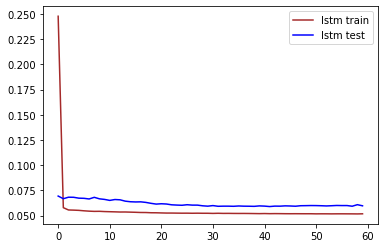

In [75]:
pyplot.plot(lstm_history.history['loss'], label='lstm train', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [77]:
test_y.reshape(2836,1)

array([[0.601784  ],
       [0.7228416 ],
       [0.6285441 ],
       ...,
       [0.65466714],
       [0.54412234],
       [0.562281  ]], dtype=float32)

In [78]:
pred_y

array([[0.6995999 ],
       [0.67028904],
       [0.72829276],
       ...,
       [0.71772283],
       [0.697055  ],
       [0.64354074]], dtype=float32)

0.006358218
0.29937321875550005
0.07973843435669795
0.05976526


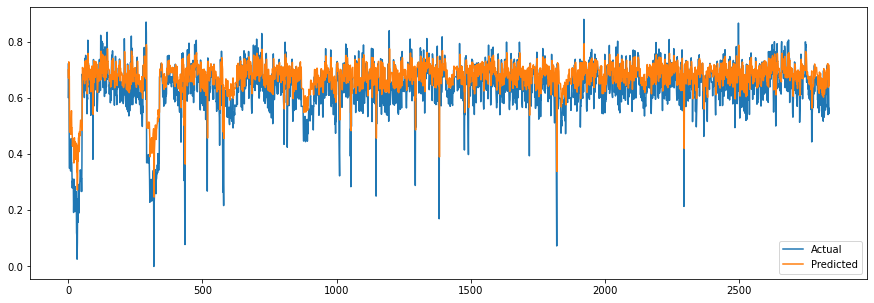

In [79]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

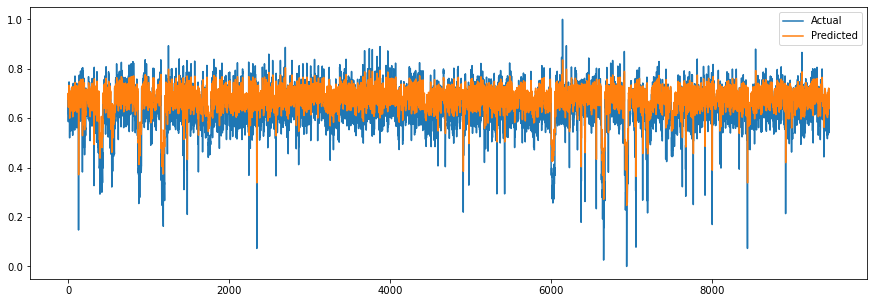

In [80]:
#visualization over full data
tra = np.concatenate([train_X,test_X])
tes = np.concatenate([train_y,test_y])
fp = model_lstm.predict(tra)
plt.plot(tes, label = 'Actual')
plt.plot(fp, label = 'Predicted')
plt.legend()
plt.show()

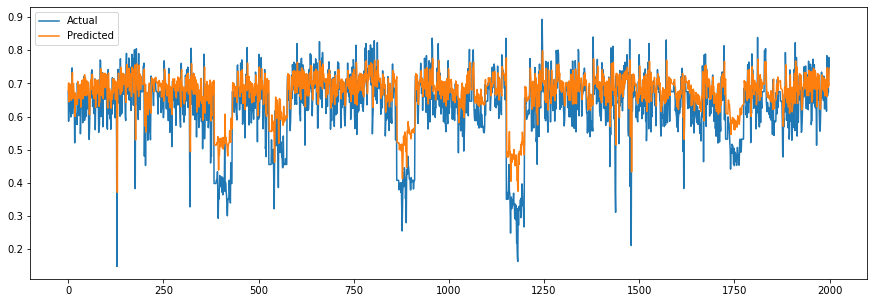

In [81]:
#over small part of data
plt.plot(tes[:2000], label = 'Actual')
plt.plot(fp[:2000], label = 'Predicted')
plt.legend()
plt.show()